In [1]:
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import time
import os
from sklearn.preprocessing import MinMaxScaler
from gensim.models import CoherenceModel 
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support 

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis 
from sklearn.linear_model import LogisticRegression 
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.ensemble import RandomForestClassifier

In [2]:
start = time.time()
df = pd.read_csv("cleandata.csv") 

start = time.time()

# Read positive words from positive-words.txt
with open("positive-words.txt", 'r') as file:
    positive_words = file.read().splitlines()

with open("negative-words.txt", 'r') as file:
    negative_words = file.read().splitlines() 

negative_words = negative_words[35:]
positive_words = positive_words[35:]

In [3]:
# Split the dataset into training and testing sets
train_data, test_data, train_labels, test_labels = train_test_split(df['review'], df['sentiment'], test_size=0.2, random_state=42)

# Apply TF-IDF transformation
tfidf_vectorizer = TfidfVectorizer(min_df=0.1, max_df=0.7, max_features=5000)
tfidf_matrix_train = tfidf_vectorizer.fit_transform(train_data)
tfidf_matrix_test = tfidf_vectorizer.transform(test_data)

# Normalize TF-IDF features
scaler = StandardScaler(with_mean=False)
tfidf_matrix_train_normalized = scaler.fit_transform(tfidf_matrix_train)
tfidf_matrix_test_normalized = scaler.transform(tfidf_matrix_test)


# Add sentiment lexicon features
sentiment_lexicon_train = pd.DataFrame(columns=['positive', 'negative'], index=train_data.index)
sentiment_lexicon_test = pd.DataFrame(columns=['positive', 'negative'], index=test_data.index)

  
for i, tokens in enumerate(train_data):
    
    sentiment_lexicon_train.loc[train_data.index[i], 'positive'] = sum(1 for word in tokens.split() if word.replace("'", "").replace(",", "").replace("[", "").replace("]", "") in positive_words)
    sentiment_lexicon_train.loc[train_data.index[i], 'negative'] = sum(1 for word in tokens.split() if word.replace("'", "").replace(",", "").replace("[", "").replace("]", "") in negative_words)

for i, tokens in enumerate(test_data):
    sentiment_lexicon_test.loc[test_data.index[i], 'positive'] = sum(1 for word in tokens.split() if word.replace("'", "").replace(",", "").replace("[", "").replace("]", "") in positive_words)
    sentiment_lexicon_test.loc[test_data.index[i], 'negative'] = sum(1 for word in tokens.split() if word.replace("'", "").replace(",", "").replace("[", "").replace("]", "") in negative_words)



# Concatenate TF-IDF matrix with sentiment lexicon features
X_train = pd.concat([pd.DataFrame(tfidf_matrix_train_normalized.toarray(), index=train_data.index), sentiment_lexicon_train], axis=1)
X_test = pd.concat([pd.DataFrame(tfidf_matrix_test_normalized.toarray(), index=test_data.index), sentiment_lexicon_test], axis=1)

X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

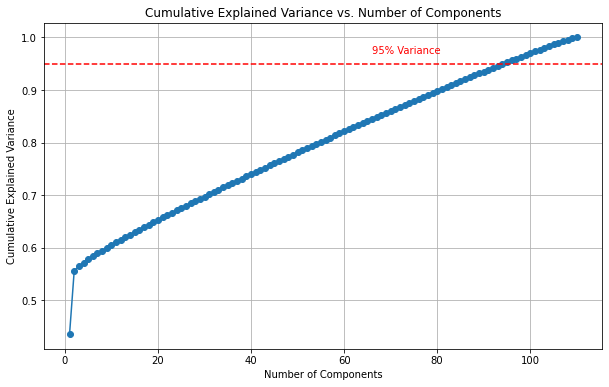

n_components: 95


In [4]:
# get PCA number of components

import numpy as np

# Apply PCA
min_samples_features = min(X_train.shape[0], X_train.shape[1])
pca = PCA(n_components=min_samples_features)  # Set n_components initially to the number of features

X_train_pca = pca.fit_transform(X_train)

# Calculate explained variance ratio
explained_variance = pca.explained_variance_ratio_
cumulative_explained_variance = explained_variance.cumsum()

# Plotting the cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, min_samples_features + 1), cumulative_explained_variance, marker='o', linestyle='-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance vs. Number of Components')
plt.grid(True)

# Calculate the index at 95% variance
desired_variance = 0.95  # Adjust as needed based on how much variance you want to retain
n_components = np.argmax(cumulative_explained_variance >= desired_variance) + 1

# Add a line for 95% variance
plt.axhline(y=desired_variance, color='r', linestyle='--', label=f'{desired_variance * 100:.0f}% Variance')
plt.text(min_samples_features * 0.6, desired_variance + 0.02, f'{desired_variance * 100:.0f}% Variance', color='r')

plt.show()

print('n_components:',n_components)

In [5]:
# Apply PCA
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Scale PCA-transformed data to ensure non-negativity
scaler = MinMaxScaler()
X_train_pca_scaled = scaler.fit_transform(X_train_pca)
X_test_pca_scaled = scaler.transform(X_test_pca)

# Split the PCA-transformed and scaled data into training and testing sets
X_train_final, X_test_final = X_train_pca_scaled, X_test_pca_scaled

Precision	Recall	F1-Score	Support
False	0.7814	0.7797	0.7805	4961
True	0.7836	0.7853	0.7844	5039

Accuracy: 0.7825

Macro Avg	0.7825	0.7825	0.7825	10000
Weighted Avg	0.7825	0.7825	0.7825	10000
650.1539790630341


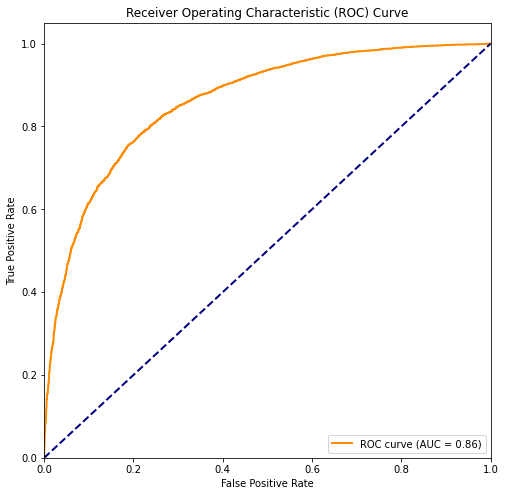

In [6]:
# Initialize Linear Discriminant Analysis (LDA) model
lda = LinearDiscriminantAnalysis()

# Fit the LDA model on training data
lda.fit(X_train_final, train_labels)

# Predictions on the test set
predictions = lda.predict(X_test_final)

# Evaluate the classification performance
report = classification_report(test_labels, predictions, target_names=['False', 'True'], output_dict=True, zero_division=1)
accuracy = accuracy_score(test_labels, predictions)

# Print the classification report
print("Precision\tRecall\tF1-Score\tSupport")
for label in ['False', 'True']:
    precision = report[label]['precision']
    recall = report[label]['recall']
    f1_score = report[label]['f1-score']
    support = report[label]['support']
    print(f"{label}\t{precision:.4f}\t{recall:.4f}\t{f1_score:.4f}\t{support}")

# Print overall accuracy
print(f"\nAccuracy: {accuracy:.4f}")

# Print macro and weighted averages
macro_avg = report['macro avg']
weighted_avg = report['weighted avg']
print("\nMacro Avg\t{:.4f}\t{:.4f}\t{:.4f}\t{:.0f}".format(macro_avg['precision'], macro_avg['recall'], macro_avg['f1-score'], macro_avg['support']))
print("Weighted Avg\t{:.4f}\t{:.4f}\t{:.4f}\t{:.0f}".format(weighted_avg['precision'], weighted_avg['recall'], weighted_avg['f1-score'], weighted_avg['support']))


# Convert categorical labels to binary labels
test_labels_binary = test_labels.replace({'negative': 0, 'positive': 1})

# Predict the probability scores for the positive class
y_scores = lda.predict_proba(X_test_final)[:, 1]


end = time.time()

elapsed_time = end-start
print(elapsed_time)

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(test_labels_binary, y_scores)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

Precision	Recall	F1-Score	Support
False	0.6874	0.7940	0.7369	4961
True	0.7607	0.6446	0.6978	5039

Accuracy: 0.7187

Macro Avg	0.7240	0.7193	0.7174	10000
Weighted Avg	0.7243	0.7187	0.7172	10000
796.8344130516052


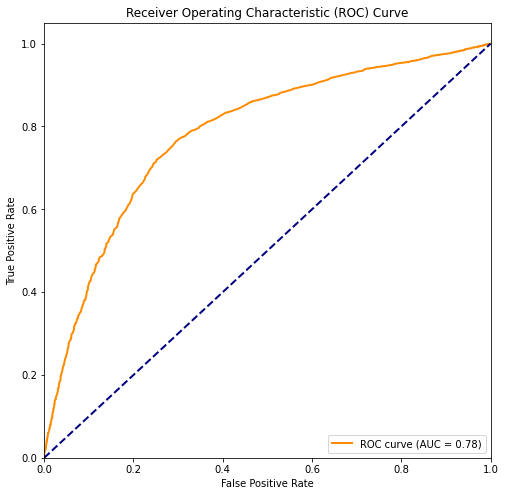

In [32]:
# Initialize Quadratic Discriminant Analysis (LDA) model
qda = QuadraticDiscriminantAnalysis() 

# Fit the QDA model on training data
qda.fit(X_train_final, train_labels)

# Predictions on the test set
predictions = qda.predict(X_test_final)

# Evaluate the classification performance
report = classification_report(test_labels, predictions, target_names=['False', 'True'], output_dict=True, zero_division=1)
accuracy = accuracy_score(test_labels, predictions)

# Print the classification report
print("Precision\tRecall\tF1-Score\tSupport")
for label in ['False', 'True']:
    precision = report[label]['precision']
    recall = report[label]['recall']
    f1_score = report[label]['f1-score']
    support = report[label]['support']
    print(f"{label}\t{precision:.4f}\t{recall:.4f}\t{f1_score:.4f}\t{support}")

# Print overall accuracy
print(f"\nAccuracy: {accuracy:.4f}")

# Print macro and weighted averages
macro_avg = report['macro avg']
weighted_avg = report['weighted avg']
print("\nMacro Avg\t{:.4f}\t{:.4f}\t{:.4f}\t{:.0f}".format(macro_avg['precision'], macro_avg['recall'], macro_avg['f1-score'], macro_avg['support']))
print("Weighted Avg\t{:.4f}\t{:.4f}\t{:.4f}\t{:.0f}".format(weighted_avg['precision'], weighted_avg['recall'], weighted_avg['f1-score'], weighted_avg['support']))


# Convert categorical labels to binary labels
test_labels_binary = test_labels.replace({'negative': 0, 'positive': 1})

# Predict the probability scores for the positive class
y_scores = qda.predict_proba(X_test_final)[:, 1]


end = time.time()

elapsed_time = end-start
print(elapsed_time)

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(test_labels_binary, y_scores)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

Precision	Recall	F1-Score	Support
False	0.7258	0.7331	0.7294	4961
True	0.7346	0.7273	0.7310	5039

Accuracy: 0.7302

Macro Avg	0.7302	0.7302	0.7302	10000
Weighted Avg	0.7302	0.7302	0.7302	10000
798.1589498519897


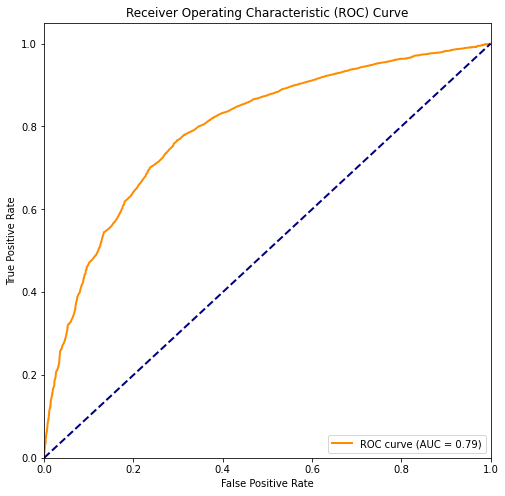

In [33]:
# Initialize Logistic Regression model
lr = LogisticRegression() 


# Fit the Logistic Regression model on training data
lr.fit(X_train_final, train_labels)

# Predictions on the test set
predictions = lr.predict(X_test_final)

# Evaluate the classification performance
report = classification_report(test_labels, predictions, target_names=['False', 'True'], output_dict=True, zero_division=1)
accuracy = accuracy_score(test_labels, predictions)

# Print the classification report
print("Precision\tRecall\tF1-Score\tSupport")
for label in ['False', 'True']:
    precision = report[label]['precision']
    recall = report[label]['recall']
    f1_score = report[label]['f1-score']
    support = report[label]['support']
    print(f"{label}\t{precision:.4f}\t{recall:.4f}\t{f1_score:.4f}\t{support}")

# Print overall accuracy
print(f"\nAccuracy: {accuracy:.4f}")

# Print macro and weighted averages
macro_avg = report['macro avg']
weighted_avg = report['weighted avg']
print("\nMacro Avg\t{:.4f}\t{:.4f}\t{:.4f}\t{:.0f}".format(macro_avg['precision'], macro_avg['recall'], macro_avg['f1-score'], macro_avg['support']))
print("Weighted Avg\t{:.4f}\t{:.4f}\t{:.4f}\t{:.0f}".format(weighted_avg['precision'], weighted_avg['recall'], weighted_avg['f1-score'], weighted_avg['support']))


# Convert categorical labels to binary labels
test_labels_binary = test_labels.replace({'negative': 0, 'positive': 1})

# Predict the probability scores for the positive class
y_scores = lr.predict_proba(X_test_final)[:, 1]


end = time.time()

elapsed_time = end-start
print(elapsed_time)

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(test_labels_binary, y_scores)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()



Precision	Recall	F1-Score	Support
False	0.7231	0.7523	0.7374	4961
True	0.7460	0.7164	0.7309	5039

Accuracy: 0.7342

Macro Avg	0.7346	0.7343	0.7342	10000
Weighted Avg	0.7347	0.7342	0.7341	10000
801.5589559078217


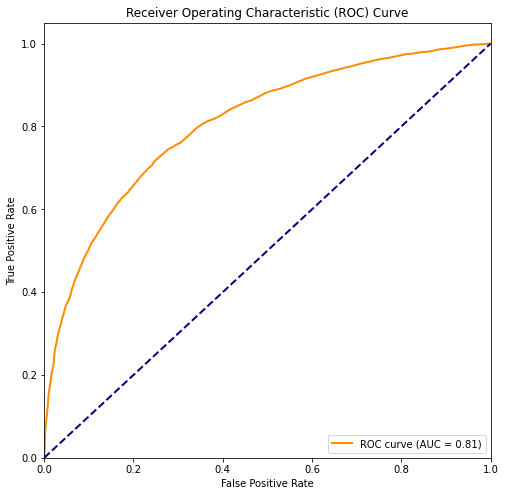

In [34]:
# Initialize KNN model
knn = KNeighborsClassifier(n_neighbors = 223)

# Fit the KNN model on training data
knn.fit(X_train_final, train_labels)

# Predictions on the test set
predictions = knn.predict(X_test_final)

# Evaluate the classification performance
report = classification_report(test_labels, predictions, target_names=['False', 'True'], output_dict=True, zero_division=1)
accuracy = accuracy_score(test_labels, predictions)

# Print the classification report
print("Precision\tRecall\tF1-Score\tSupport")
for label in ['False', 'True']:
    precision = report[label]['precision']
    recall = report[label]['recall']
    f1_score = report[label]['f1-score']
    support = report[label]['support']
    print(f"{label}\t{precision:.4f}\t{recall:.4f}\t{f1_score:.4f}\t{support}")

# Print overall accuracy
print(f"\nAccuracy: {accuracy:.4f}")

# Print macro and weighted averages
macro_avg = report['macro avg']
weighted_avg = report['weighted avg']
print("\nMacro Avg\t{:.4f}\t{:.4f}\t{:.4f}\t{:.0f}".format(macro_avg['precision'], macro_avg['recall'], macro_avg['f1-score'], macro_avg['support']))
print("Weighted Avg\t{:.4f}\t{:.4f}\t{:.4f}\t{:.0f}".format(weighted_avg['precision'], weighted_avg['recall'], weighted_avg['f1-score'], weighted_avg['support']))


# Convert categorical labels to binary labels
test_labels_binary = test_labels.replace({'negative': 0, 'positive': 1})

# Predict the probability scores for the positive class
y_scores = knn.predict_proba(X_test_final)[:, 1]


end = time.time()

elapsed_time = end-start
print(elapsed_time)

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(test_labels_binary, y_scores)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


Precision	Recall	F1-Score	Support
False	0.7199	0.7398	0.7297	4961
True	0.7366	0.7166	0.7265	5039

Accuracy: 0.7281

Macro Avg	0.7283	0.7282	0.7281	10000
Weighted Avg	0.7283	0.7281	0.7281	10000
818.1925287246704


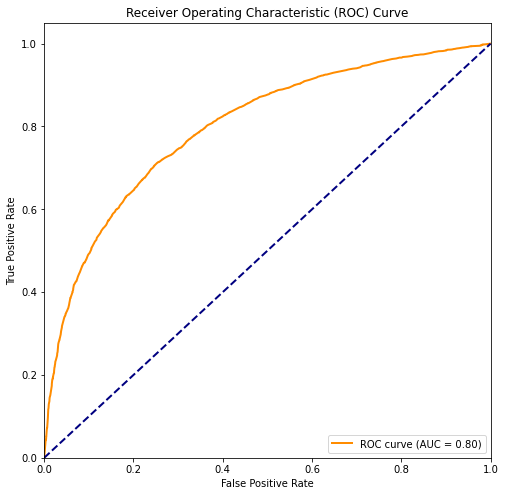

In [35]:
# Initialize Random Forest model
rf = RandomForestClassifier(n_estimators = 300, random_state = 1) 

# Fit the Random Forest model on training data
rf.fit(X_train_final, train_labels)

# Predictions on the test set
predictions = rf.predict(X_test_final)

# Evaluate the classification performance
report = classification_report(test_labels, predictions, target_names=['False', 'True'], output_dict=True, zero_division=1)
accuracy = accuracy_score(test_labels, predictions)

# Print the classification report
print("Precision\tRecall\tF1-Score\tSupport")
for label in ['False', 'True']:
    precision = report[label]['precision']
    recall = report[label]['recall']
    f1_score = report[label]['f1-score']
    support = report[label]['support']
    print(f"{label}\t{precision:.4f}\t{recall:.4f}\t{f1_score:.4f}\t{support}")

# Print overall accuracy
print(f"\nAccuracy: {accuracy:.4f}")

# Print macro and weighted averages
macro_avg = report['macro avg']
weighted_avg = report['weighted avg']
print("\nMacro Avg\t{:.4f}\t{:.4f}\t{:.4f}\t{:.0f}".format(macro_avg['precision'], macro_avg['recall'], macro_avg['f1-score'], macro_avg['support']))
print("Weighted Avg\t{:.4f}\t{:.4f}\t{:.4f}\t{:.0f}".format(weighted_avg['precision'], weighted_avg['recall'], weighted_avg['f1-score'], weighted_avg['support']))


# Convert categorical labels to binary labels
test_labels_binary = test_labels.replace({'negative': 0, 'positive': 1})

# Predict the probability scores for the positive class
y_scores = rf.predict_proba(X_test_final)[:, 1]


end = time.time()

elapsed_time = end-start
print(elapsed_time)

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(test_labels_binary, y_scores)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
